# Notion of sampling distribution, standard error and confidence interval

Recall the estimators for the mean and variance:
$$\hat{X}=\frac{1}{N} \sum_{i=1}^{N}x_{i}$$
$$\hat{V}=\frac{1}{N-1} \sum_{i=1}^{N}(x_{i}-\hat{x})^2$$


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, lognorm

## Notion of sampling distribution

Say we are looking at the conductivity K of a soil.

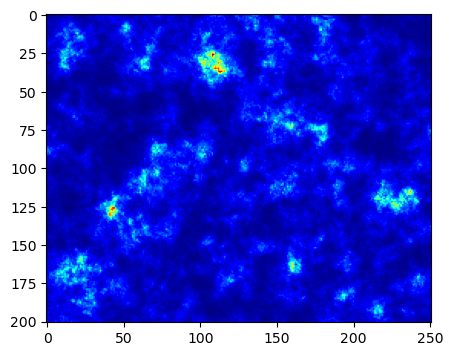

In [17]:
data = pd.read_csv('log_conductivity_fields.csv', header=0)
conductivity = np.exp(data['log_conductivity_1'].to_numpy())
Lx = 251
Ly = 201
fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(conductivity.reshape(Ly, Lx), cmap = 'jet')
plt.show()

In this example I actually knew the true population distribution and thus true mean:

1.2956246574284747
True mean of the population = 1.284


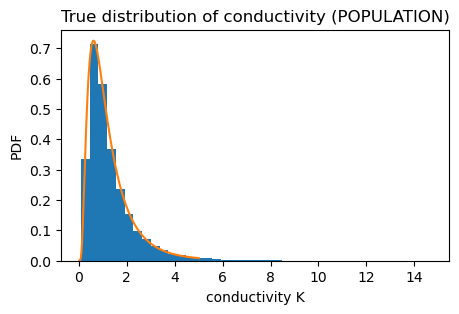

In [18]:
from scipy.stats import lognorm
population_dist = lognorm(s=np.sqrt(0.5), loc=0, scale=1)
print(np.mean(conductivity))

print('True mean of the population = {:.3f}'.format(population_dist.mean()))

fig, ax = plt.subplots(figsize=(5, 3))
xx = np.linspace(0, 5, 200)
ax.hist(conductivity, density=True, bins=40)
ax.plot(xx, population_dist.pdf(xx))
ax.set_title('True distribution of conductivity (POPULATION)')
ax.set_xlabel('conductivity K')
ax.set_ylabel('PDF')
plt.show()

In practice we can only measure conductivity at a few points!

We want to estimate the average conductivity... we go in the field and measure conductivity at some points.

Question: if sample points are very close in space, are my data points independent?

In [19]:
# Sample conductivity at random within field
# Question: if I sample points too close, would those be independent?
def sample_conductivity(N):
    return np.random.choice(conductivity, size=N, replace=False)

In [23]:
print('This is one dataset with N=50 samples:')
one_dataset = sample_conductivity(N=50)
print(np.round(one_dataset, 3))
print()
print('This is the sample mean from the above dataset:')
m = np.mean(one_dataset)
print(np.round(m, 3))


This is one dataset with N=50 samples:
[1.51  1.349 2.881 1.57  0.273 0.372 1.082 0.594 0.939 0.395 1.33  0.345
 3.934 0.876 0.37  0.887 3.394 0.494 0.19  1.865 0.187 0.715 0.86  1.439
 1.531 1.925 0.418 0.66  0.382 3.808 0.919 1.148 0.668 0.782 0.707 0.855
 0.425 1.2   0.306 2.625 2.994 5.019 0.796 1.61  1.358 1.364 1.582 0.536
 2.383 0.686]

This is the sample mean from the above dataset:
1.291


Now say we collect 2000 separate datasets (!!!) and compute the average conductivity for each of them. The distribution of all the mean values is the sampling distribution of the mean.

In [24]:
all_means = []
for i in range(2000):
    data = sample_conductivity(N=50)
    m = np.mean(data)
    all_means.append(m)

print(len(all_means))
print(all_means[:10])

2000
[1.3167693599074073, 1.0899871145427715, 1.244497431128149, 1.068155831498062, 1.5143510712218293, 1.0462522477223144, 1.268583690591558, 1.1868448124332618, 1.603577350127607, 1.3803035566492454]


Plot a histogram of the sampling distribution of the mean

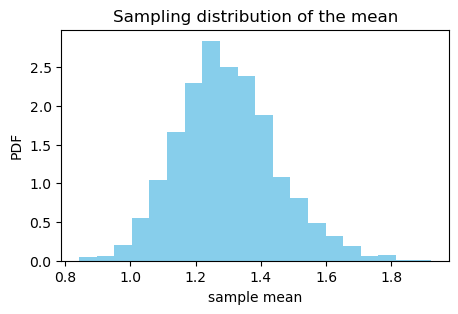

Mean of the sampling distribution = 1.296
Std. dev. of the sampling distribution = Standard Error = 0.152


In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(all_means, density=True, bins=20, color='skyblue')
ax.set_xlabel('sample mean')
ax.set_ylabel('PDF')
ax.set_title(r'Sampling distribution of the mean')
plt.show()

print('Mean of the sampling distribution = {:.3f}'.format(np.mean(all_means)))
print('Std. dev. of the sampling distribution = Standard Error = {:.3f}'.format(np.std(all_means, ddof=1)))

What happens if we vary N?

N=10
Std. dev. of the sampling distribution = Standard Error = 0.337
N=20
Std. dev. of the sampling distribution = Standard Error = 0.240
N=100
Std. dev. of the sampling distribution = Standard Error = 0.107


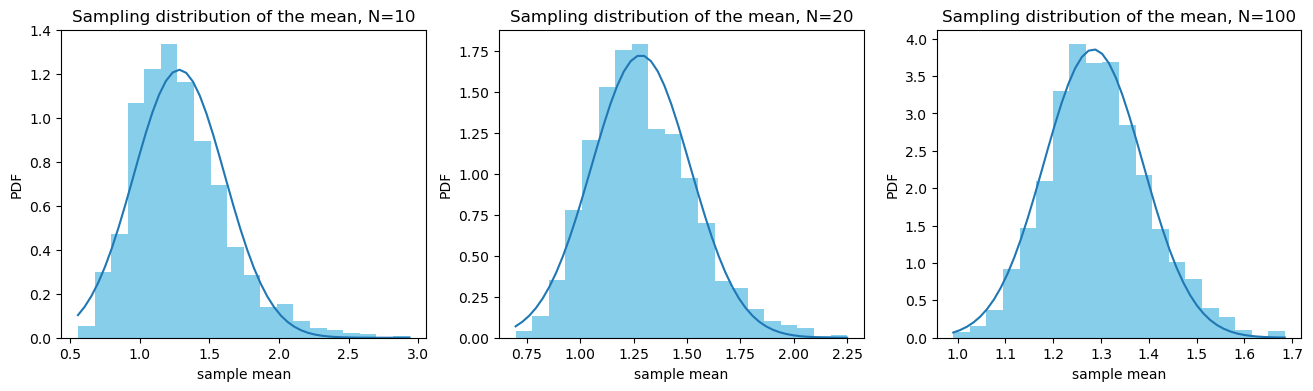

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

N_values = [10, 20, 100]
for i, N in enumerate(N_values):
    print('N={}'.format(N))
    # plot histogram of the sampling distribution of the mean
    all_means = []
    for j in range(2000):
        data = sample_conductivity(N=N)
        m = np.mean(data)
        all_means.append(m)
        
    ax[i].hist(all_means, density=True, bins=20, color='skyblue')
    approx_gauss = norm(loc=population_dist.mean(), scale=population_dist.std()/np.sqrt(N))
    xx = np.linspace(min(all_means), max(all_means))
    ax[i].plot(xx, approx_gauss.pdf(xx))
    ax[i].set_xlabel('sample mean')
    ax[i].set_ylabel('PDF')
    ax[i].set_title(r'Sampling distribution of the mean, N={}'.format(N))
    
    print('Std. dev. of the sampling distribution = Standard Error = {:.3f}'.format(np.std(all_means, ddof=1)))

plt.show()


## Hypothesis testing

SHM example

In [10]:
df = pd.read_csv('shm_dataset.csv', header=0)
data_healthy = df['healthy_state'].dropna().to_numpy()
data_unknown_state = df['unknown_state'].dropna().to_numpy()
print(len(data_healthy), len(data_unknown_state))
df.head()

100 25


,healthy_state,unknown_state
0,4.199219,4.296875
1,4.296875,4.296875
2,4.101562,4.199219
3,4.101562,4.492188
4,4.199219,4.101562


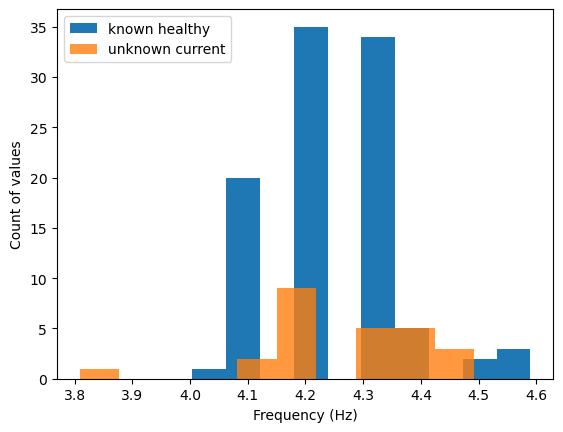

In [15]:
fig, ax = plt.subplots()
ax.hist(data_healthy, label='known healthy')
ax.hist(data_unknown_state, alpha=0.8, label='unknown current')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Count of values')
plt.legend()
plt.show()

### Testing against a fixed value

$\mu$ is frequency of structure in its current unknown condition. $\mu_0$ is fixed value we compare against = design frequency of heatlhy structure ($\mu_0=4.4$ Hz)

H0: $\mu=\mu_0$ (conclusion: structure is healthy)

H1: $\mu \neq \mu_0$ (conclusion: structure is damaged)

In [12]:
from scipy.stats import ttest_1samp
mu_0 = 4.1
_, p_value = ttest_1samp(a=data_unknown_state, popmean=mu_0)
print('p-value = {:.5f}'.format(p_value))

p-value = 0.00001


p_value is very small, meaning that the difference between known mean $\mu_0$ and sample average from data is statistically significant (we can reject H0 in favor of H1)

### Testing between two samples

In general, we do not have perfect knowledge of the natural frequency in the structure's heatlhy state, which also varies slightly because of environmental conditions. Thus we often take measurements when we know the structure is healthy (right after construsction say) and compute the mean natural frequency ($\mu_1$), then compare with the current mean natural frequency ($\mu_2$).

H0: $\mu_1=\mu_2$ (conclusion: structure is healthy)

H1: $\mu_1 \neq \mu_2$ (conclusion: structure is damaged)

In [14]:
from scipy.stats import ttest_ind
_, p_value = ttest_ind(a=data_healthy, b=data_unknown_state, equal_var=False)
print('p-value = {:.5f}'.format(p_value))

p-value = 0.33776


The p-value is very large, meaning that we cannot draw a conclusion about the difference of means here... the difference of natural frequencies we observe could be due to random sampling.